# Solving Blackjack with Q-Learning

Install the OpenAI gym package to get the Blackjack environment

In [0]:
!pip install gym

Install and load the profiler for later optimizations

Import the following packages as wel'll need it later

In [0]:
import gym
import numpy as np
import random

Load up the Blackjack Environment

In [0]:
env = gym.make("Blackjack-v0")

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


For the curious, we'll display the state and action space size for the game

In [0]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(2)
State Space Tuple(Discrete(32), Discrete(11), Discrete(2))


## Q Learning Agent

The QAgent class is going to house all the logic necessary to have a Q-Learning Agent. Since there's a lot going on here, this section will be longer than the others.

### Parameters

There are several parameters that are hard-coded into the model that should be tweaked when applying it to different problems to see if it affects performance. We will describe each parameter briefly here.



* Epsilon: The exploration rate. How often will the agent choose a random move during training instead of relying on information it already has. Helps the agent go down paths it normally wouldn't in hopes for higher long term rewards.
  - Epsilon Decay: How much our epsilon decreases after each update
  - Epsilon Min: The lowest rate of exploration we'll allow during training
* Gamma: Discount rate. This tells us how much we prioritize current versus future rewards.
* Alpha: Affects how much we shift our knowledge based off of new information.



### Fixed Q-Targets

In Q-Learning we update our Q_Table through the following function:

$Q_{TableEntry}(state, action) = Reward + max(Q_{TableEntry}(state))$

Since our update is dependent on the same table itself, we can start to get correlated entries. This could cause oscillations to happen in our training. 

To combat this, we implemented a target model. It essentially is a copy of the original model, except that the values do not update as rapidly. The rate at which the target model updates is dependent upon `Alpha` in our parameter list.

### Agent Workflow

1. Create an empty q-table for both the model and target model.
2. Given a starting state, perform an action.
3. Once you performed the action on the environment, update the model with information you have gained through the environment: reward, next state, if the environment is finished, etc.
4. Then calculate the value of the state.
  - If the game is finished, then the reward is the value of that state.
  - If not, then take the current reward and add the discounted reward of future states.
5. Update the model with the new value.
6. Decay the epsilon value as described in the parameters.
7. Gradually update the target model.
8. Perform an action for the new state, either randomly through epsilon, or by choosing the best action based on what we currently know.
9. Repeat steps 3-8.

In [0]:
class QAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.gamma = 0.95 # Discount Rate
    self.epsilon = 1.0 # Exploration Rate
    self.epsilon_min = 0.001
    self.epsilon_decay = 0.9995
    self.model = self._build_model()
    ## Additional components for Fixed Q-Targets
    self.target_model = self._build_model()
    # Update the target model by 10% each iteration
    self.alpha = 0.1
    
  def _build_model(self):
    # Assumes both self.state_size and self.action_size are lists
    model = np.zeros(self.state_size + self.action_size)
    return model
  
  def update_target_model(self):
    self.target_model = (1 - self.alpha) * self.target_model + self.alpha * self.model
  
  
  def act_random(self):
    return random.randrange(self.action_size[0])
  
  def best_act(self, state):
    # Choose the best action based on what we know
    # If all the action values are the same, then choose randomly
    action = self.act_random() if np.all(self.target_model[state, 0] == self.target_model[state]) else np.argmax(self.target_model[state])
    return action
  
  def act(self, state):
    # Act randomly epsilon percent of time, otherwise act greedily
    action = self.act_random() if np.random.rand() <= self.epsilon else self.best_act(state)
    return action
  
  def update(self, state, action, reward, next_state, done):
    target = reward
    if not done:
      target = reward + self.gamma * np.amax(self.target_model[next_state])
    self.model[state, action] = target
    self.update_target_model()
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
      
  
  def load(self, name):
    self.model.load_weights(name)
    
  def save(self, name):
    self.model.save_weights(name)

## Training

Now that we have defined our agent, let us train it through playing a lot of games. By the end of it, we would hope that the agent has been through a variety of situations and have learned the best way to combat each one.

In [0]:
"""Training the agent"""
state_size =  [ x.n for x in env.observation_space.spaces ]
action_size = [ env.action_space.n ]
agent = QAgent(state_size, action_size)

num_episodes = 5000000
num_episodes = 1000000
for i in range(1, num_episodes):
  # State is tuple instead of number, figure it out
  state = env.reset()
  state = (state[0], state[1], int(state[2]))
  
  epochs, reward = 0, 0
  done = False
  
  while not done:
    action = agent.act(state)
    
    next_state, reward, done, info = env.step(action)
    next_state = (next_state[0], next_state[1], int(next_state[2]))
    
    agent.update(state, action, reward, next_state, done)
   
    state = next_state
    
    epochs += 1

print("Training Finished.\n")

## Evaluate Performance of agent

Now that we have trained the agent, let us check to see how it performs. This step looks very similar to the training aspect, we are just not allowing the agent to choose randomly every so often anymore and we're not updating the agent based on its experiences.

In [0]:
"""Evaluate agent's performance after Q-learning"""
episodes = 10000
total_epochs = 0
rewards = []
for i in range(episodes):
    state = env.reset()
    state = (state[0], state[1], int(state[2]))

    epochs, reward = 0, 0
    
    done = False
    
    while not done:
        action = agent.best_act(state)
        state, reward, done, info = env.step(action)
        state = (state[0], state[1], int(state[2]))
        
        epochs += 1
    
    total_epochs += epochs
    rewards.append(reward)

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Total reward: { sum(rewards) }")

Results after 10000 episodes:
Average timesteps per episode: 1.0
Total reward: -1879.0


## Analysis of Performance

To begin this analysis, we will need the pandas library

In [0]:
import pandas as pd

Now we wish to take our rewards vector and count how many wins, loses, and draws there were in our simulation.

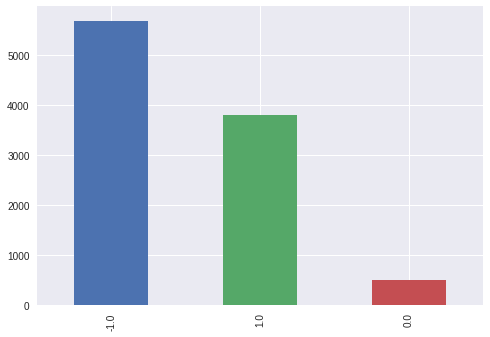

In [0]:
rewards_df = pd.DataFrame(rewards, columns=['r'])
rewards_count_df = rewards_df['r'].value_counts()
rewards_count_df.plot(kind='bar')

If we divide it by the total number of simulated runs, we get the proportions of wins/loses/draws.

In [0]:
rewards_prop_df = (rewards_count_df / rewards_df.shape[0]) * 100
rewards_prop_df # Percent in each category

-1.0    56.84
 1.0    38.05
 0.0     5.11
Name: r, dtype: float64

### But how does it compare to Brute Force Performance?

The following code will run through a lot of games of Blackjack, where the agent chooses randomly the entire time. We will keep track of the wins, loses, and draws as before.

In [0]:
"""Evaluate brute force performance"""

total_epochs = 0
episodes = 10000
rewards = []

for i in range(episodes):
    state = env.reset()
    s1, s2, s3 = state
    s3 = int(s3)
    epochs, reward = 0, 0
    
    done = False
    
    while not done:
        action = action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        s1, s2, s3 = state
        s3 = int(s3)
        
        epochs += 1
    
    total_epochs += epochs
    rewards.append(reward)

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Total reward: { sum(rewards) }")

Results after 10000 episodes:
Average timesteps per episode: 1.3724
Total reward: -4183.0


With this information we can provide the same statistics as prior.

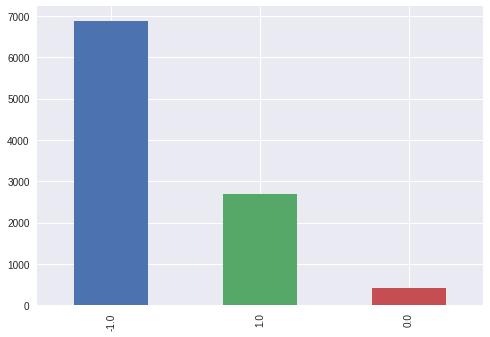

In [0]:
rewards_df = pd.DataFrame(rewards, columns=['r'])
rewards_count_df = rewards_df['r'].value_counts()
rewards_count_df.plot(kind='bar')

In [0]:
rewards_prop_df = (rewards_count_df / rewards_df.shape[0]) * 100
rewards_prop_df # Percent in each category

-1.0    68.85
 1.0    27.02
 0.0     4.13
Name: r, dtype: float64